In [1]:
# !pip install gekko
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

#### Solve Linear Equations

$
3x + 2y = 1 \\
x + 2y = 0
$

In [7]:
m = GEKKO()            # create GEKKO model
x = m.Var()            # define new variable, default=0
y = m.Var()            # define new variable, default=0
m.Equations([3*x+2*y==1, x+2*y==0])  # equations
m.solve(disp=False)    # solve
print(x.value,y.value) # print solution

[0.5] [-0.25]


#### Nonlinear Programming Optimization

$
\min x_1x_4(x_1 + x_2 + x_3) + x_3 \\
\text{s.t.} \quad x_1x_2x_3x_4 \geq 25 \\
x_1^2 + x_2^2 + x_3^2 + x_4^2 = 40 \\
0 \leq x_1, x_1, x_1, x_1 \leq 5 \\
x_0 = (1, 5, 5, 1)
$

In [8]:
m = GEKKO() # Initialize gekko
# Use IPOPT solver (default)
m.options.SOLVER = 3
# Change to parallel linear solver
m.solver_options = ['linear_solver ma97']
# Initialize variables
x1 = m.Var(value=1,lb=1,ub=5)
x2 = m.Var(value=5,lb=1,ub=5)
x3 = m.Var(value=5,lb=1,ub=5)
x4 = m.Var(value=1,lb=1,ub=5)
# Equations
m.Equation(x1*x2*x3*x4>=25)
m.Equation(x1**2+x2**2+x3**2+x4**2==40)
m.Obj(x1*x4*(x1+x2+x3)+x3) # Objective
m.options.IMODE = 3 # Steady state optimization
m.solve(disp=False) # Solve

In [9]:
print('Results')
print('x1: ' + str(x1.value))
print('x2: ' + str(x2.value))
print('x3: ' + str(x3.value))
print('x4: ' + str(x4.value))
print('Objective: ' + str(m.options.objfcnval))

Results
x1: [1.000000057]
x2: [4.74299963]
x3: [3.8211500283]
x4: [1.3794081795]
Objective: 17.014017127


#### Mixed Integer Nonlinear Programming

$x_1, x_2$ are continuous, $x_3, x_4$ are integer

In [11]:
m = GEKKO() # Initialize gekko
m.options.SOLVER=1  # APOPT is an MINLP solver

# optional solver settings with APOPT
m.solver_options = ['minlp_maximum_iterations 500', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 10', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 50', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 1', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.05', \
                    # covergence tolerance
                    'minlp_gap_tol 0.01']

# Initialize variables
x1 = m.Var(value=1,lb=1,ub=5)
x2 = m.Var(value=5,lb=1,ub=5)
# Integer constraints for x3 and x4
x3 = m.Var(value=5,lb=1,ub=5,integer=True)
x4 = m.Var(value=1,lb=1,ub=5,integer=True)
# Equations
m.Equation(x1*x2*x3*x4>=25)
m.Equation(x1**2+x2**2+x3**2+x4**2==40)
m.Obj(x1*x4*(x1+x2+x3)+x3) # Objective
m.solve(disp=False) # Solve

In [12]:
print('Results')
print('x1: ' + str(x1.value))
print('x2: ' + str(x2.value))
print('x3: ' + str(x3.value))
print('x4: ' + str(x4.value))
print('Objective: ' + str(m.options.objfcnval))

Results
x1: [1.3589086474]
x2: [4.5992789966]
x3: [4.0]
x4: [1.0]
Objective: 17.532267301


#### Optimal Control

$
\min_{u} \frac{1}{2} \int_0^2 x^2(T) dt \\
\text{s.t.} \quad \dot{x} = u \\
x(0) = 1 \\
-1 \leq u(t) \leq 1 \\
$

Equivalent form for GEKKO:

$
\min_{u} x_2(t) \\
\text{s.t.} \quad \\
\dot{x_1} = u \\
\dot{x_2} = \frac{1}{2} x_1^2(t) \\
x_1(0) = 1 \\
x_2(0) = 0 \\
T = 2 \\
-1 \leq u(t) \leq 1 \\
$

In [2]:
m = GEKKO() # initialize gekko
nt = 101
m.time = np.linspace(0,2,nt)

# Variables
x1 = m.Var(value=1)
x2 = m.Var(value=0)
u = m.Var(value=0,lb=-1,ub=1)
p = np.zeros(nt) # mark final time point
p[-1] = 1.0
final = m.Param(value=p)

# Equations
m.Equation(x1.dt()==u)
m.Equation(x2.dt()==0.5*x1**2)
m.Obj(x2*final) # Objective function
m.options.IMODE = 6 # optimal control mode
m.solve(disp=False) # solve

Text(0, 0.5, 'Value')

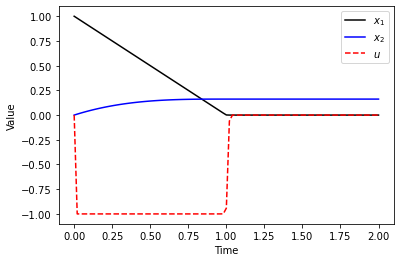

In [15]:
plt.figure(1) # plot results
plt.plot(m.time,x1.value,'k-',label=r'$x_1$')
plt.plot(m.time,x2.value,'b-',label=r'$x_2$')
plt.plot(m.time,u.value,'r--',label=r'$u$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')

#### Our Mixed-Integer Nonlinear Optimal Control Problem

$
\begin{array}{rll}
\text{continuous time}: & 
    \dot{x}(t) = f_c(x(t), b(t)) = x^3(t) - b(t) \ , & 
    t \in \mathbb{R}_{\geq 0} \\
\text{discrete time}: & 
    x^{+} = f_d(x, b, k) = \text{Runge-Kutta-4}\ (f_c) \ , & 
    k \in \mathbb{Z}_{\geq 0}
\end{array}
$

$
\textbf{x} = (x(0), x(1), \dots, x(N)) \\
\textbf{b} = (b(0), b(1), \dots, b(N-1)) \\
\textbf{b} \in \mathbb{Z}^{N} \cap \mathbb{B}, \; \text{where} \;
\mathbb{Z} = \{0, 1\}, \;
\mathbb{B} = 
\left\{ b \in [0, 1]^N \mid \begin{align} 
    & b(k) \geq b(k-1) - b(k-2) \\
    & b(k) \geq b(k-1) - b(k-2) 
\end{align} \right\}
$

$
\text{objetive function}:
F(\textbf{x}, \textbf{b}) = \frac{1}{2} \sum\limits^{N}_{k=0} (x(k) - x_{ref})^2
$

$
\textbf{MINLP}: 
\min\limits_{\textbf{x}, \textbf{b}}
F(\textbf{x}, \textbf{b}) \\
\text{such that} \\
x^{+} = f_d(x, b, k) \\
x(0) = x_0 \\
\textbf{b} \in \mathbb{Z}^{N} \cap \mathbb{B} \\
N = 30, \ x_0 = 0.8, \ x_{ref} = 0.7
$